In [11]:
#!/usr/bin/env python3
"""
Aggregate LoRA vs BayesLoRA curves from runs/ folders and plot:
 - Top: accuracy vs epoch (mean ± std) for LoRA and vLoRA
 - Bottom: total effective rank vs epoch (mean ± std)
 - Inset zoom on the last K epochs of the accuracy panel

Usage:
  python plot_agg_curves.py \
    --base_dir bayeslora/runs \
    --dataset cifar10 \
    --metric acc_mean \
    --zoom_last 5 \
    --outfile bayeslora/figs/cifar10_lora_vs_vlora.png
"""

import argparse, os, glob, csv, json, re, math
from typing import Dict, List, Tuple
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ------------------------ helpers ------------------------

def detect_method_from_path_or_row(run_dir: str, row_run_str: str = "") -> str:
    """
    Return 'lora' or 'vlora' using multiple hints:
    - folder name contains '_lora_' → 'lora', contains '_vlora_' → 'vlora'
    - else, row 'run' string (from epochs.csv) contains the tokens
    Fallback: if 'vlora' in any → 'vlora', elif 'lora' → 'lora', else 'unknown'
    """
    name = os.path.basename(run_dir).lower()
    srcs = [name, (row_run_str or "").lower()]
    for s in srcs:
        if "_vlora_" in s or "bayeslora" in s or re.search(r"\bvlora\b", s):
            return "vlora"
    for s in srcs:
        if "_lora_" in s or re.search(r"\blora\b", s):
            return "lora"
    return "unknown"


def load_epochs_csv(run_dir: str) -> pd.DataFrame:
    path = os.path.join(run_dir, "epochs.csv")
    if not os.path.isfile(path):
        return pd.DataFrame()
    try:
        df = pd.read_csv(path)
        # Ensure expected columns exist
        # 'run','epoch','acc_mean','acc_mc','total_rank' (added by your script)
        return df
    except Exception:
        return pd.DataFrame()


def filter_by_dataset(run_dir: str, dataset: str) -> bool:
    """
    Keep runs whose folder name OR epochs.csv 'run' field contains the dataset token.
    This keeps it robust to naming conventions like 'cifar10_vlora_...' etc.
    """
    ds = dataset.lower()
    name = os.path.basename(run_dir).lower()
    if ds in name:
        return True
    # Fallback: peek at config.json (if present)
    cfgp = os.path.join(run_dir, "config.json")
    if os.path.isfile(cfgp):
        try:
            with open(cfgp, "r") as f:
                cfg = json.load(f)
            if str(cfg.get("dataset", "")).lower() == ds:
                return True
        except Exception:
            pass
    return False


def gather_runs(base_dir: str, dataset: str) -> Dict[str, List[pd.DataFrame]]:
    """
    Walk base_dir/*, load epochs.csv, bucket into 'lora' and 'vlora' lists.
    Only include runs that match the requested dataset.
    """
    buckets = {"lora": [], "vlora": []}
    for run_dir in sorted(glob.glob(os.path.join(base_dir, "*"))):
        if not os.path.isdir(run_dir):
            continue
        if not filter_by_dataset(run_dir, dataset):
            continue
        df = load_epochs_csv(run_dir)
        if df.empty or "epoch" not in df.columns:
            continue
        # Detect method using folder name or the first row's 'run' string
        meth = detect_method_from_path_or_row(run_dir, df.get("run", [""])[0] if "run" in df.columns else "")
        if meth in buckets:
            # guard: ensure numeric epoch
            df = df.copy()
            df["epoch"] = pd.to_numeric(df["epoch"], errors="coerce")
            df = df.dropna(subset=["epoch"])
            df["epoch"] = df["epoch"].astype(int)
            buckets[meth].append(df)
    return buckets


def aggregate_by_epoch(dfs: List[pd.DataFrame], value_col: str) -> pd.DataFrame:
    """
    Given multiple run DataFrames, align by epoch and compute mean/std for value_col.
    Returns a tidy DataFrame with columns: epoch, mean, std, n
    """
    if not dfs:
        return pd.DataFrame(columns=["epoch", "mean", "std", "n"]).astype({"epoch": int})
    # Outer-join on epoch by concatenation then groupby
    vals = []
    for i, df in enumerate(dfs):
        if value_col not in df.columns:
            continue
        sub = df[["epoch", value_col]].dropna().copy()
        sub = sub.rename(columns={value_col: f"v{i}"})
        vals.append(sub)
    if not vals:
        return pd.DataFrame(columns=["epoch", "mean", "std", "n"]).astype({"epoch": int})
    # Merge all on epoch
    merged = vals[0]
    for k in range(1, len(vals)):
        merged = pd.merge(merged, vals[k], on="epoch", how="outer")
    merged = merged.sort_values("epoch")
    # Row-wise stats across the v* columns
    vcols = [c for c in merged.columns if c.startswith("v")]
    merged["mean"] = merged[vcols].mean(axis=1, skipna=True)
    merged["std"]  = merged[vcols].std(axis=1, ddof=1, skipna=True)
    merged["n"]    = merged[vcols].count(axis=1)
    out = merged[["epoch", "mean", "std", "n"]].copy()
    out["epoch"] = out["epoch"].astype(int)
    return out


def add_mean_std(ax: Axes, df: pd.DataFrame, label: str, linestyle: str = "-"):
    """
    Plot mean ± std shaded region for a curve defined by df(epoch, mean, std).
    """
    if df.empty:
        return
    ax.plot(df["epoch"], df["mean"], linestyle=linestyle, label=label)
    if "std" in df.columns and df["std"].notna().any():
        y1 = df["mean"] - df["std"]
        y2 = df["mean"] + df["std"]
        ax.fill_between(df["epoch"], y1, y2, alpha=0.15)


# ------------------------ plotting ------------------------

def plot_curves(
    acc_lora: pd.DataFrame,
    acc_vlora: pd.DataFrame,
    rank_lora: pd.DataFrame,
    rank_vlora: pd.DataFrame,
    metric_name: str,
    zoom_last: int = 4,
    title: str = "",
    outfile: str = None,
):
    fig, (ax_acc, ax_rank) = plt.subplots(
        2, 1, figsize=(9, 7), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
    )

    # Top: accuracy curves
    add_mean_std(ax_acc, acc_lora, f"LoRA ({metric_name})", "-")
    add_mean_std(ax_acc, acc_vlora, f"BayesLoRA ({metric_name})", "--")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.yaxis.set_major_locator(MaxNLocator(6))
    if title:
        ax_acc.set_title(title)
    ax_acc.grid(True, alpha=0.3)
    #ax_acc.legend(loc="lower right")

    # Inset zoom on the tail
    try:
        if zoom_last and max(acc_lora["epoch"].max() if not acc_lora.empty else 0,
                             acc_vlora["epoch"].max() if not acc_vlora.empty else 0) > 0:
            max_epoch = 0
            if not acc_lora.empty:
                max_epoch = max(max_epoch, int(acc_lora["epoch"].max()))
            if not acc_vlora.empty:
                max_epoch = max(max_epoch, int(acc_vlora["epoch"].max()))
            x0 = max(1, max_epoch - int(zoom_last) + 1)
            x1 = max_epoch

            axins = inset_axes(ax_acc, width="40%", height="55%", loc="lower right", borderpad=1.1)
            add_mean_std(axins, acc_lora[(acc_lora["epoch"] >= x0) & (acc_lora["epoch"] <= x1)],
                         f"LoRA ({metric_name})", "-")
            add_mean_std(axins, acc_vlora[(acc_vlora["epoch"] >= x0) & (acc_vlora["epoch"] <= x1)],
                         f"BayesLoRA ({metric_name})", "--")
            axins.set_xlim(x0, x1)
            # Nice y-lims with small padding
            tail_vals = []
            for df in (acc_lora, acc_vlora):
                if not df.empty:
                    dd = df[(df["epoch"] >= x0) & (df["epoch"] <= x1)]
                    tail_vals += dd["mean"].tolist()
            if tail_vals:
                ymin, ymax = min(tail_vals), max(tail_vals)
                pad = max(1e-3, 0.02 * (ymax - ymin if ymax > ymin else 1.0))
                axins.set_ylim(ymin - pad, ymax + pad)
            axins.grid(True, alpha=0.2)
            axins.set_xticks([x0, x1])
            axins.set_yticks([])
            axins.set_title(f"Last {zoom_last} epochs", fontsize=9)
    except Exception:
        pass

    # Bottom: effective rank curves
    add_mean_std(ax_rank, rank_lora, "LoRA", "-")
    add_mean_std(ax_rank, rank_vlora, "BayesLoRA", "--")
    ax_rank.set_xlabel("Epoch")
    ax_rank.set_ylabel("Total effective rank")
    ax_rank.yaxis.set_major_locator(MaxNLocator(6))
    ax_rank.grid(True, alpha=0.3)
    ax_rank.legend(loc="best")

    plt.tight_layout()
    if outfile:
        os.makedirs(os.path.dirname(outfile), exist_ok=True)
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
        print(f"Saved figure to: {outfile}")
    else:
        plt.show()

/tmp/ipykernel_7561/4153915965.py:225: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


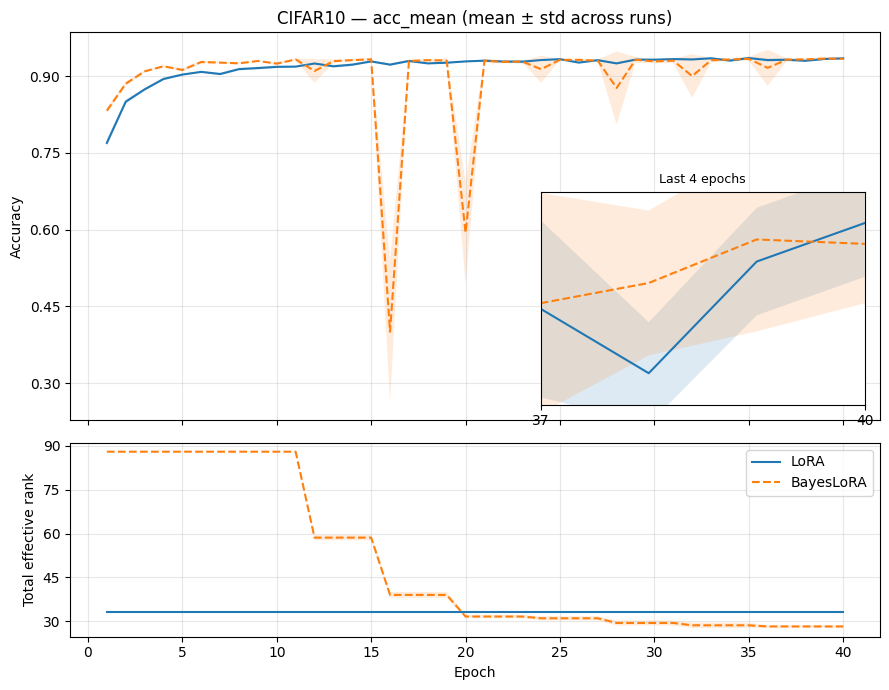

In [12]:
# ------------------------ main ------------------------

dataset = 'cifar10'
metric = "acc_mean"
zoom_last = 4
outfile = ''

buckets = gather_runs('./runs', dataset)

# Aggregate accuracy & rank per method
acc_lora  = aggregate_by_epoch(buckets["lora"],  metric)
acc_vlora = aggregate_by_epoch(buckets["vlora"], metric)
rank_lora  = aggregate_by_epoch(buckets["lora"],  "total_rank")
rank_vlora = aggregate_by_epoch(buckets["vlora"], "total_rank")

# Nice title
title = f"{dataset.upper()} — {metric} (mean ± std across runs)"

# Plot
outfile = outfile if outfile else None
plot_curves(acc_lora, acc_vlora, rank_lora, rank_vlora,
            metric_name=metric, zoom_last=zoom_last, title=title, outfile=outfile)

In [13]:
acc_vlora

,epoch,mean,std,n
0,1,0.83254,0.005566,5
1,2,0.88524,0.003996,5
2,3,0.90932,0.002269,5
3,4,0.91934,0.001655,5
4,5,0.91210,0.003400,5
5,6,0.92768,0.002854,5
6,7,0.92648,0.001633,5
7,8,0.92508,0.002204,5
8,9,0.92968,0.000522,5
9,10,0.92448,0.002732,5
